In [23]:
#Import libraries

import numpy as np
import pandas as pd
import quandl
import datetime
import math
import math
from sklearn import preprocessing, model_selection as cross_validation, svm
from sklearn.linear_model import LinearRegression


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

data = quandl.get("WIKI/AMZN",api_key='a8dTJ3RyANCXeuWMn-En')
data.head()
df = pd.DataFrame(data, columns=['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume', 'High', 'Low'])
df = df.reset_index()
df.head()

,Date,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,High,Low
0,1997-05-16,1.865000,1.979167,1.708333,1.729167,14700000.0,23.75,20.50
1,1997-05-19,1.708333,1.770833,1.625000,1.708333,6106800.0,21.25,19.50
2,1997-05-20,1.729167,1.750000,1.635833,1.635833,5467200.0,21.00,19.63
3,1997-05-21,1.604167,1.645833,1.375000,1.427500,18853200.0,19.75,16.50
4,1997-05-22,1.437500,1.448333,1.312500,1.395833,11776800.0,17.38,15.75


In [24]:
# Check for missing values in the columns
df.isna().values.any()
#There is missing values in the dataset

False

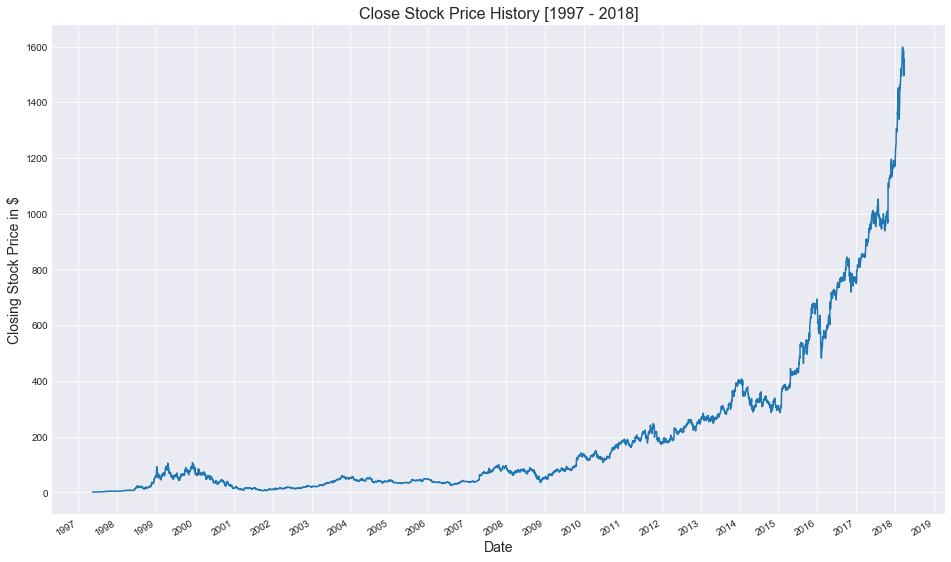

In [25]:
# Import matplotlib package for date plots
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

years = mdates.YearLocator() # Get every year
yearsFmt = mdates.DateFormatter('%Y') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Adj. Close'])

# Format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set figure title
plt.title('Close Stock Price History [1997 - 2018]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# When we take a look at the price movement over time by simply plotting the Closing price vs Time, 
# we can see, that the price continously increases over time and we can also estimate that 
# trend is linear.

In [26]:
df['Mid_Price'] = (df['High'] + df['Low']) / 2

df = df[['Adj. Close', 'Mid_Price', 'Adj. Volume']]
forecast_col = 'Adj. Close'

forecast_out = int(math.ceil(0.001 * len(df)))
df['Prediction'] = df[forecast_col].shift(-forecast_out)

# X is the input data and excludes labels to be predicted
X = np.array(df.drop(['Prediction'], 1))

#Preprocessing gets values between -1 and 1
X = preprocessing.scale(X)

#Input for which prediction is needed
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

#Output to be predicted
y = np.array(df['Prediction'])

#Use linear regression classifier 80% - 20%
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Confidence:', confidence)
y_pred = clf.predict(X_test)

Confidence: 0.997692891718839


In [27]:
# Generate 25 random numbers
randints = np.random.randint(5242, size=25)

# Select row numbers == random numbers
df_sample = df[df.index.isin(randints)]
df_sample.head()

,Adj. Close,Mid_Price,Adj. Volume,Prediction
371,21.633333,129.300,20383200.0,21.833333
410,53.550000,323.550,18298200.0,92.300000
424,61.500000,112.325,43765800.0,57.950000
468,69.550000,142.600,24922000.0,91.450000
510,60.450000,113.200,21158600.0,54.200000


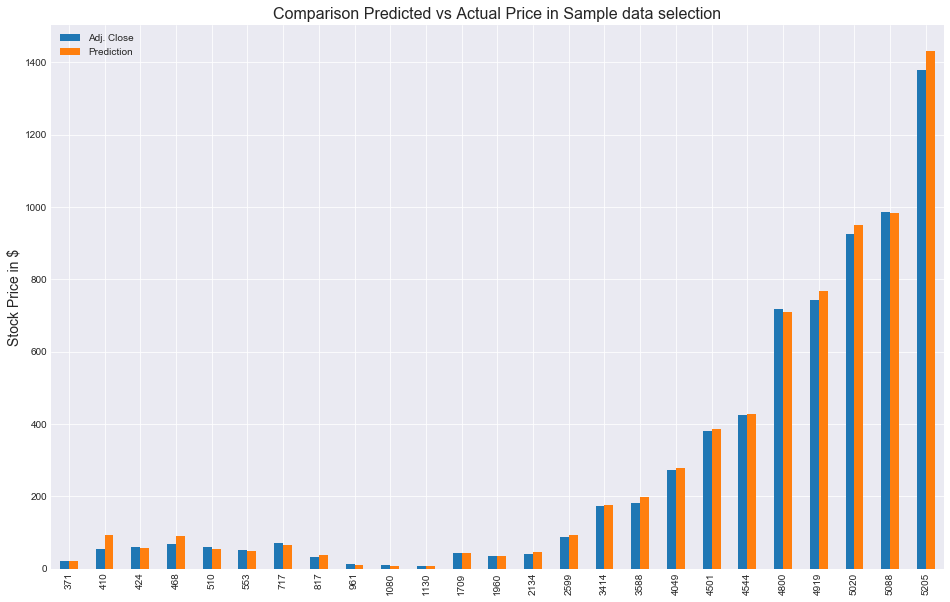

In [28]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
df_sample.plot(y=['Adj. Close', 'Prediction'], kind='bar', ax=ax)

# Set figure title
plt.title('Comparison Predicted vs Actual Price in Sample data selection', fontsize=16)

# Set y label
plt.ylabel('Stock Price in $', fontsize=14)

# Show plot
plt.show()

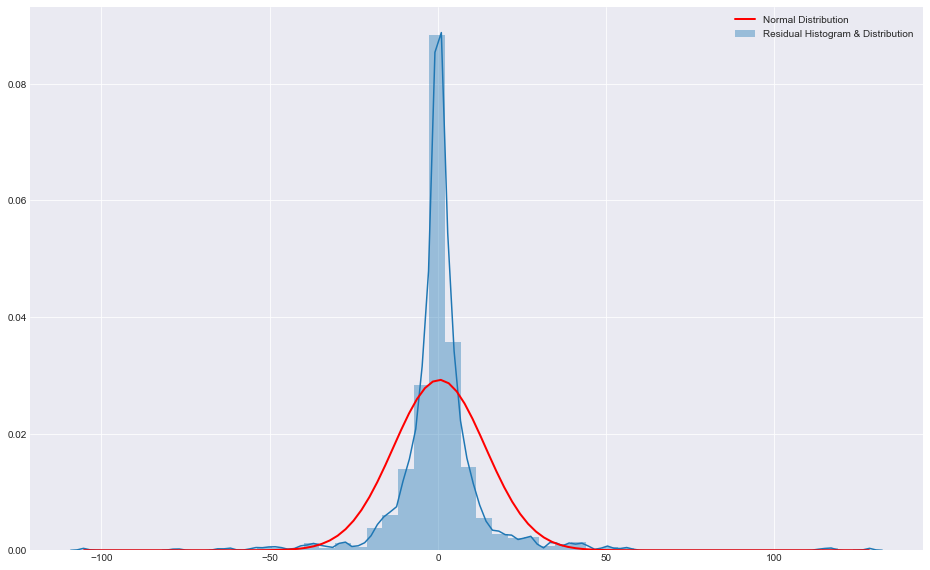

In [29]:
# Import norm package to plot normal distribution
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(y_test - y_pred)

ax = sns.distplot((y_test - y_pred), label='Residual Histogram & Distribution')

# Calculate the pdf over a range of values         
x = np.linspace(min(y_test - y_pred), max(y_test - y_pred), 100)
p = norm.pdf(x, mu, std)

# And plot on the same axes that seaborn put the histogram
ax.plot(x, p, 'r', lw=2, label='Normal Distribution') 

plt.legend()
plt.show()

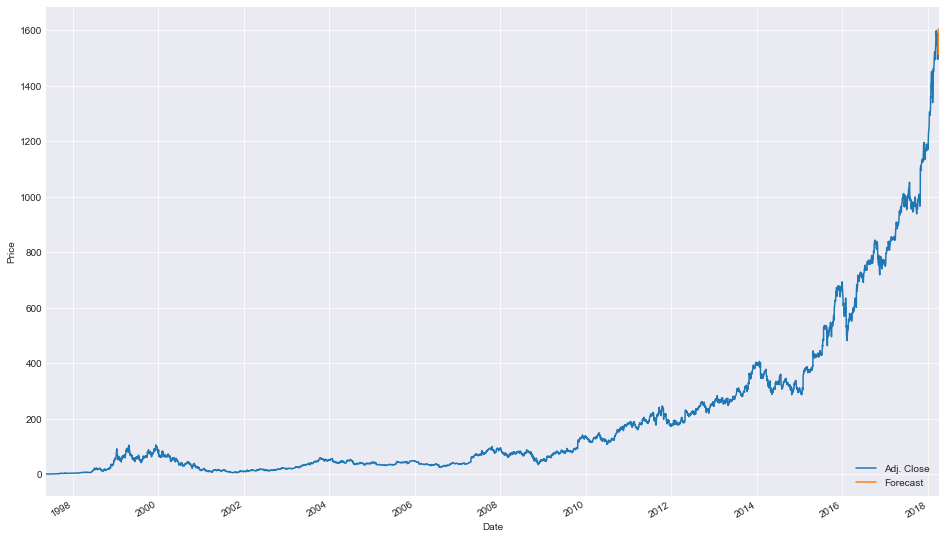

In [30]:
df = pd.DataFrame(data, columns=['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume'])
#Predict for the forecast set
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

#Predict for every day after the last day in training set
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]


#Plot the graph for visualizayion
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#Store the model
import pickle
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)